In [1]:
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import spearmanr, pearsonr

import seaborn as sns

from basenji.gene import gtf_kv
from basenji import gene as bgene

from sklearn.metrics import average_precision_score, roc_auc_score

#Function require that a crispr row exists in both dataframes, or that it is beyond a certain distance from TSS
def intersect_or_beyond(crispr_df_1, crispr_df_2, distance_within=0) :
    
    #Get natural keys
    crispr_df_1['join_id'] = crispr_df_1['chr'] + '_' + crispr_df_1['start'].astype(str) + '_' + crispr_df_1['end'].astype(str) + '_' + crispr_df_1['gene'].astype(str)
    crispr_df_2['join_id'] = crispr_df_2['chr'] + '_' + crispr_df_2['start'].astype(str) + '_' + crispr_df_2['end'].astype(str) + '_' + crispr_df_2['gene'].astype(str)
    
    #Filter dataframe copies
    crispr_df_1_copy = crispr_df_1.loc[(crispr_df_1['tss_distance'] > distance_within) | (crispr_df_1['join_id'].isin(crispr_df_2['join_id'].values.tolist()))].copy()
    crispr_df_2_copy = crispr_df_2.loc[(crispr_df_2['tss_distance'] > distance_within) | (crispr_df_2['join_id'].isin(crispr_df_1['join_id'].values.tolist()))].copy()
    
    return crispr_df_1_copy, crispr_df_2_copy

#Function to compute accuracy stats for crispr benchmark
def accuracy_stats(crispr_df, n_bootstrap=1000, lo=0.025, hi=0.975, distance_boundaries=[0, 15000, 60000, 130000, 262144]) :
  
    col_names = ['dist', 'sites', 'pos', 'auc', 'ap', 'tss_auc', 'tss_ap', 'auc_lo', 'auc_med', 'auc_hi', 'ap_lo', 'ap_med', 'ap_hi']
    print('\t'.join(col_names))
    
    lines = []
    
    #Loop over distance boundaries
    for di in range(len(distance_boundaries) - 1) :
        
        #Apply distance filter
        distance_mask = (crispr_df.tss_distance > distance_boundaries[di])
        distance_mask &= (crispr_df.tss_distance <= distance_boundaries[di+1])
        dcrispr_df = crispr_df[distance_mask]

        #Get number of sites
        num_sites = dcrispr_df.shape[0]
        num_pos = dcrispr_df.regulate.sum()

        #Compute accuracies
        if num_sites < 2 or num_pos < 1 :
            auroc_model = np.nan
            auprc_model = np.nan
            auroc_tss = np.nan
            auprc_tss = np.nan

        else :
            auroc_model = roc_auc_score(dcrispr_df.regulate, dcrispr_df.score)
            auprc_model = average_precision_score(dcrispr_df.regulate, dcrispr_df.score)
            auroc_tss = roc_auc_score(dcrispr_df.regulate, 1./dcrispr_df.tss_distance)
            auprc_tss = average_precision_score(dcrispr_df.regulate, 1./dcrispr_df.tss_distance)
        
        #Estimate confidence interval by bootstrapping
        auroc_model_bootstrap = []
        auprc_model_bootstrap = []
        if n_bootstrap > 0 :
            
            #Loop over bootstrap samples
            for sample_ix in range(n_bootstrap) :
                
                #Resample data with replacement
                bootstrap_index = np.random.choice(np.arange(len(dcrispr_df)).tolist(), size=(len(dcrispr_df),), replace=True).tolist()
                dcrispr_df_bootstrap = dcrispr_df.iloc[bootstrap_index].copy()
                
                #Get number of sites
                num_sites_bootstrap = dcrispr_df_bootstrap.shape[0]
                num_pos_bootstrap = dcrispr_df_bootstrap.regulate.sum()

                #Compute accuracies
                if num_sites_bootstrap < 2 or num_pos_bootstrap < 1 :
                    auroc_model_bootstrap.append(np.nan)
                    auprc_model_bootstrap.append(np.nan)
                else :
                    auroc_model_bootstrap.append(roc_auc_score(dcrispr_df_bootstrap.regulate, dcrispr_df_bootstrap.score))
                    auprc_model_bootstrap.append(average_precision_score(dcrispr_df_bootstrap.regulate, dcrispr_df_bootstrap.score))
        
        auroc_model_lo = np.nan
        auroc_model_med = np.nan
        auroc_model_hi = np.nan
        auprc_model_lo = np.nan
        auprc_model_med = np.nan
        auprc_model_hi = np.nan
        if n_bootstrap > 0 :
            auroc_model_lo = np.quantile(auroc_model_bootstrap, q=lo)
            auroc_model_med = np.median(auroc_model_bootstrap)
            auroc_model_hi = np.quantile(auroc_model_bootstrap, q=hi)
            auprc_model_lo = np.quantile(auprc_model_bootstrap, q=lo)
            auprc_model_med = np.median(auprc_model_bootstrap)
            auprc_model_hi = np.quantile(auprc_model_bootstrap, q=hi)
        
        #Print accuracies
        cols = [str(distance_boundaries[di+1]), str(num_sites), str(num_pos)]
        cols += ['%.4f' % auroc_model, '%.4f' % auprc_model]
        cols += ['%.4f' % auroc_tss, '%.4f' % auprc_tss]
        cols += ['%.4f' % auroc_model_lo, '%.4f' % auroc_model_med, '%.4f' % auroc_model_hi]
        cols += ['%.4f' % auprc_model_lo, '%.4f' % auprc_model_med, '%.4f' % auprc_model_hi]
        
        lines.append('\t'.join(cols))
        
        print(lines[-1])
    
    #Create dataframe with stats
    stats_df = pd.DataFrame([li.split('\t') for li in lines], columns=col_names)
    
    return stats_df

#Function to compute fold change stats for crispr benchmark
def fc_stats(crispr_df, n_bootstrap=1000, lo=0.025, hi=0.975, distance_boundaries=[0, 15000, 60000, 130000, 262144]) :
  
    col_names = ['dist', 'sites', 'pos', 'fc', 'fc_lo', 'fc_med', 'fc_hi']
    print('\t'.join(col_names))
    
    lines = []
    
    #Loop over distance boundaries
    for di in range(len(distance_boundaries) - 1) :
        
        #Apply distance filter
        distance_mask = (crispr_df.tss_distance > distance_boundaries[di])
        distance_mask &= (crispr_df.tss_distance <= distance_boundaries[di+1])
        dcrispr_df = crispr_df[distance_mask]

        #Get number of sites
        num_sites = dcrispr_df.shape[0]
        num_pos = dcrispr_df.regulate.sum()

        #Compute accuracies
        if num_sites < 2 or num_pos < 1 :
            fc_model = np.nan
        else :
            fc_model = dcrispr_df.query("regulate == True")['pct_change'].abs().mean() / dcrispr_df.query("regulate == False")['pct_change'].abs().mean()
        
        #Estimate confidence interval by bootstrapping
        fc_model_bootstrap = []
        if n_bootstrap > 0 :
            
            #Loop over bootstrap samples
            for sample_ix in range(n_bootstrap) :
                
                #Resample data with replacement
                bootstrap_index = np.random.choice(np.arange(len(dcrispr_df)).tolist(), size=(len(dcrispr_df),), replace=True).tolist()
                dcrispr_df_bootstrap = dcrispr_df.iloc[bootstrap_index].copy()
                
                #Get number of sites
                num_sites_bootstrap = dcrispr_df_bootstrap.shape[0]
                num_pos_bootstrap = dcrispr_df_bootstrap.regulate.sum()

                #Compute accuracies
                if num_sites_bootstrap < 2 or num_pos_bootstrap < 1 :
                    fc_model_bootstrap.append(np.nan)
                else :
                    fc_model_bootstrap.append(dcrispr_df_bootstrap.query("regulate == True")['pct_change'].abs().mean() / dcrispr_df_bootstrap.query("regulate == False")['pct_change'].abs().mean())
        
        fc_model_lo = np.nan
        fc_model_med = np.nan
        fc_model_hi = np.nan
        if n_bootstrap > 0 :
            fc_model_lo = np.quantile(fc_model_bootstrap, q=lo)
            fc_model_med = np.median(fc_model_bootstrap)
            fc_model_hi = np.quantile(fc_model_bootstrap, q=hi)
        
        #Print accuracies
        cols = [str(distance_boundaries[di+1]), str(num_sites), str(num_pos)]
        cols += ['%.4f' % fc_model]
        cols += ['%.4f' % fc_model_lo, '%.4f' % fc_model_med, '%.4f' % fc_model_hi]
        
        lines.append('\t'.join(cols))
        
        print(lines[-1])
    
    #Create dataframe with stats
    stats_df = pd.DataFrame([li.split('\t') for li in lines], columns=col_names)
    
    return stats_df

#Function to plot barchart with model performance 
def plot_bars(model_names, model_dfs, model_colors, limit_x=False, legend_outside=False, model_hatches=None, fig_size=(8, 3), plot_title='FlowFISH - Gradients (gaussian)', metric='ap', metric_str='AUPRC', distances=[15000, 60000, 130000, 262000], distance_strs=['< 15kb', '15kb - 60kb', '60kb - 130kb', '130kb - 262kb'], y_min=0.0, y_max=1.0, save_name=None) : 
    
    n_models = len(model_names)
    n_distances = len(distances)

    f = plt.figure(figsize=fig_size, dpi=300)

    distances_x = np.arange(len(distances))

    #Loop over models
    for model_i in range(n_models) :

        #Plot metrics
        acc_val = np.array(model_dfs[model_i][metric].astype('float32').values, dtype='float32')
        acc_lo = np.array(model_dfs[model_i][metric + '_lo'].astype('float32').values, dtype='float32')
        acc_hi = np.array(model_dfs[model_i][metric + '_hi'].astype('float32').values, dtype='float32')

        hatch = None if model_hatches is None else model_hatches[model_i]
        
        plt.bar(distances_x * (n_models + 0.5) + model_i, acc_val, width=0.8, color=model_colors[model_i], hatch=hatch, label=model_names[model_i], edgecolor='black', linewidth=0.5)

        #Plot bootstrap confidence interval
        for distance_i in range(n_distances) :
            if acc_lo[distance_i] != acc_val[distance_i] and acc_hi[distance_i] != acc_val[distance_i] :

                x_mid = (distances_x * (n_models + 0.5) + model_i)[distance_i]
                acc_lo_val = acc_lo[distance_i]
                acc_hi_val = acc_hi[distance_i]

                plt.plot([x_mid - 0.35, x_mid + 0.35], [acc_lo_val, acc_lo_val], linewidth=0.5, linestyle='-', color='red')
                plt.plot([x_mid, x_mid], [acc_lo_val, acc_hi_val], linewidth=0.5, linestyle='--', color='red')
                plt.plot([x_mid - 0.35, x_mid + 0.35], [acc_hi_val, acc_hi_val], linewidth=0.5, linestyle='-', color='red')

    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)

    if limit_x :
        plt.xlim(-1.5, len(distances) * (n_models + 0.5))
    
    plt.xticks(distances_x * (n_models + 0.5) + n_models / 2. - 0.5, distance_strs, fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.ylabel(metric_str, fontsize=10)

    if not legend_outside :
        plt.legend(fontsize=8)
    else :
        plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=3)

    plt.title(plot_title, fontsize=10)

    plt.tight_layout()
    
    if save_name is not None :
        plt.savefig(save_name + '.eps')

    plt.show()


In [2]:
#Load dataframes

#Borzoi gradients
crispr_df_borzoi_f0_grad_average = pd.read_csv("site_scores_gasperini_k562_grad_borzoi_f0_average.csv", sep='\t')
crispr_df_borzoi_ensemble_grad_average = pd.read_csv("site_scores_gasperini_k562_grad_borzoi_ensemble_average.csv", sep='\t')
crispr_df_borzoi_ensemble_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_borzoi_ensemble_gaussian.csv", sep='\t')

#Borzoi ism shuffles
crispr_df_borzoi_f0_ism = pd.read_csv("site_scores_gasperini_k562_ism_borzoi_f0.csv", sep='\t')
crispr_df_borzoi_ensemble_ism = pd.read_csv("site_scores_gasperini_k562_ism_borzoi_ensemble.csv", sep='\t')

#Enformer gradients
crispr_df_enformer_grad_average = pd.read_csv("site_scores_gasperini_k562_grad_enformer2_average.csv", sep='\t')
crispr_df_enformer_grad_average3 = pd.read_csv("site_scores_gasperini_k562_grad_enformer3_average.csv", sep='\t')
crispr_df_enformer_grad_max = pd.read_csv("site_scores_gasperini_k562_grad_enformer2_max.csv", sep='\t')
crispr_df_enformer_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_enformer2_gaussian.csv", sep='\t')
crispr_df_enformer_grad_gaussian3 = pd.read_csv("site_scores_gasperini_k562_grad_enformer3_gaussian.csv", sep='\t')
crispr_df_enformer_grad_gaussian_max = pd.read_csv("site_scores_gasperini_k562_grad_enformer2_gaussian_max.csv", sep='\t')

#Enformer ism shuffles
crispr_df_enformer_ism = pd.read_csv("site_scores_gasperini_k562_ism_enformer2.csv", sep='\t')
crispr_df_enformer_ism_max = pd.read_csv("site_scores_gasperini_k562_ism_enformer2_max.csv", sep='\t')

#Apply intersections and filter crispr rows

distance_within = 98000

#Gradients (average)
crispr_df_borzoi_f0_grad_average, crispr_df_enformer_grad_average = intersect_or_beyond(crispr_df_borzoi_f0_grad_average, crispr_df_enformer_grad_average, distance_within=distance_within)
crispr_df_enformer_grad_average3, _ = intersect_or_beyond(crispr_df_enformer_grad_average3, crispr_df_enformer_grad_average, distance_within=distance_within)
crispr_df_enformer_grad_max, _ = intersect_or_beyond(crispr_df_enformer_grad_max, crispr_df_enformer_grad_average, distance_within=distance_within)
crispr_df_borzoi_ensemble_grad_average, _ = intersect_or_beyond(crispr_df_borzoi_ensemble_grad_average, crispr_df_enformer_grad_average, distance_within=distance_within)

#Gradients (gaussian)
crispr_df_borzoi_ensemble_grad_gaussian, crispr_df_enformer_grad_gaussian = intersect_or_beyond(crispr_df_borzoi_ensemble_grad_gaussian, crispr_df_enformer_grad_gaussian, distance_within=distance_within)
crispr_df_enformer_grad_gaussian3, _ = intersect_or_beyond(crispr_df_enformer_grad_gaussian3, crispr_df_enformer_grad_gaussian, distance_within=distance_within)
crispr_df_enformer_grad_gaussian_max, _ = intersect_or_beyond(crispr_df_enformer_grad_gaussian_max, crispr_df_enformer_grad_gaussian, distance_within=distance_within)

#ISM Shuffle
crispr_df_borzoi_f0_ism, crispr_df_enformer_ism = intersect_or_beyond(crispr_df_borzoi_f0_ism, crispr_df_enformer_ism, distance_within=distance_within)
crispr_df_borzoi_ensemble_ism, _ = intersect_or_beyond(crispr_df_borzoi_ensemble_ism, crispr_df_enformer_ism, distance_within=distance_within)
crispr_df_enformer_ism_max, _ = intersect_or_beyond(crispr_df_enformer_ism_max, crispr_df_enformer_ism, distance_within=distance_within)


In [3]:
#Evaluate borzoi scores (gradients; one fold; average)

print("-- borzoi scores (gradients; one fold; average) --")

#Compute and print accuracy stats
stats_df_borzoi_grad_f0 = accuracy_stats(
    crispr_df_borzoi_f0_grad_average,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)


-- borzoi scores (gradients; one fold; average) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1230	179	0.7627	0.5183	0.6970	0.4406	0.7204	0.7620	0.8023	0.4441	0.5200	0.5897
45000	2445	103	0.7144	0.1274	0.5338	0.0612	0.6615	0.7158	0.7628	0.0892	0.1325	0.1936
98000	4058	65	0.7074	0.0681	0.5789	0.0226	0.6350	0.7084	0.7734	0.0404	0.0741	0.1305
262144	10051	45	0.6887	0.0614	0.6568	0.0082	0.5827	0.6882	0.7844	0.0189	0.0631	0.1333


In [4]:
#Evaluate borzoi scores (gradients; ensemble; average)

print("-- borzoi scores (gradients; ensemble; average) --")

#Compute and print accuracy stats
stats_df_borzoi_grad = accuracy_stats(
    crispr_df_borzoi_ensemble_grad_average,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

#Evaluate enformer scores (gradients; average)

print("")
print("-- enformer scores (gradients; average) --")

#Compute and print accuracy stats
stats_df_enformer_grad = accuracy_stats(
    crispr_df_enformer_grad_average,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

print("")
print("-- enformer scores (gradients; 3 bins; average) --")

#Compute and print accuracy stats
stats_df_enformer_grad3 = accuracy_stats(
    crispr_df_enformer_grad_average3,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

print("")
print("-- enformer scores (gradients; average; max) --")

#Compute and print accuracy stats
stats_df_enformer_grad_max = accuracy_stats(
    crispr_df_enformer_grad_max,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)


-- borzoi scores (gradients; ensemble; average) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1230	179	0.7961	0.5608	0.6970	0.4406	0.7569	0.7981	0.8334	0.4878	0.5638	0.6307
45000	2445	103	0.7655	0.1814	0.5338	0.0612	0.7151	0.7644	0.8111	0.1223	0.1851	0.2615
98000	4058	65	0.7760	0.1301	0.5789	0.0226	0.7031	0.7745	0.8377	0.0789	0.1364	0.2245
262144	10051	45	0.7429	0.1138	0.6568	0.0082	0.6477	0.7458	0.8293	0.0410	0.1193	0.2336

-- enformer scores (gradients; average) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1230	179	0.7389	0.4978	0.6970	0.4406	0.6897	0.7391	0.7842	0.4126	0.4990	0.5746
45000	2445	103	0.6404	0.0962	0.5338	0.0612	0.5863	0.6391	0.6943	0.0648	0.1013	0.1580
98000	4058	65	0.7099	0.0761	0.5789	0.0226	0.6443	0.7095	0.7771	0.0386	0.0811	0.1554
262144	0	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan

-- enformer scores (gradients; 3 bins; average) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	

In [5]:
#Evaluate borzoi scores (gradients; ensemble; gaussian)

print("-- borzoi scores (gradients; ensemble; gaussian) --")

#Compute and print accuracy stats
stats_df_borzoi_grad_gaussian = accuracy_stats(
    crispr_df_borzoi_ensemble_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

#Evaluate enformer scores (gradients; gaussian)

print("")
print("-- enformer scores (gradients; gaussian) --")

#Compute and print accuracy stats
stats_df_enformer_grad_gaussian = accuracy_stats(
    crispr_df_enformer_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

print("")
print("-- enformer scores (gradients; 3 bins; gaussian) --")

#Compute and print accuracy stats
stats_df_enformer_grad_gaussian3 = accuracy_stats(
    crispr_df_enformer_grad_gaussian3,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

print("")
print("-- enformer scores (gradients; gaussian; max) --")

#Compute and print accuracy stats
stats_df_enformer_grad_gaussian_max = accuracy_stats(
    crispr_df_enformer_grad_gaussian_max,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)


-- borzoi scores (gradients; ensemble; gaussian) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1230	179	0.7892	0.5569	0.6970	0.4406	0.7479	0.7880	0.8305	0.4805	0.5592	0.6304
45000	2445	103	0.7652	0.1892	0.5338	0.0612	0.7102	0.7659	0.8144	0.1365	0.1954	0.2646
98000	4058	65	0.7889	0.1214	0.5789	0.0226	0.7183	0.7892	0.8591	0.0720	0.1295	0.2115
262144	10051	45	0.7545	0.1186	0.6568	0.0082	0.6615	0.7516	0.8434	0.0450	0.1199	0.2366

-- enformer scores (gradients; gaussian) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1230	179	0.7427	0.5334	0.6970	0.4406	0.6957	0.7419	0.7857	0.4587	0.5336	0.5989
45000	2445	103	0.6574	0.1113	0.5338	0.0612	0.5979	0.6566	0.7120	0.0730	0.1138	0.1726
98000	4058	65	0.7107	0.0698	0.5789	0.0226	0.6322	0.7108	0.7768	0.0371	0.0725	0.1337
262144	0	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan

-- enformer scores (gradients; 3 bins; gaussian) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_m

-- borzoi scores (ism shuffle; ensemble) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1230	179	0.7393	0.4346	0.6970	0.4406	0.6983	0.7390	0.7819	0.3618	0.4350	0.5156
45000	2445	103	0.6880	0.1388	0.5338	0.0612	0.6286	0.6882	0.7475	0.0943	0.1460	0.2131
98000	4058	65	0.7403	0.0935	0.5789	0.0226	0.6729	0.7425	0.8048	0.0555	0.0999	0.1669
262144	10051	45	0.6849	0.0796	0.6568	0.0082	0.5768	0.6883	0.7825	0.0254	0.0835	0.1824
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1230	179	3.7369	3.0238	3.7255	4.5938
45000	2445	103	2.7277	2.1017	2.7181	3.5071
98000	4058	65	3.7394	2.5957	3.7072	5.0477
262144	10051	45	6.7357	3.6466	6.5749	10.6169


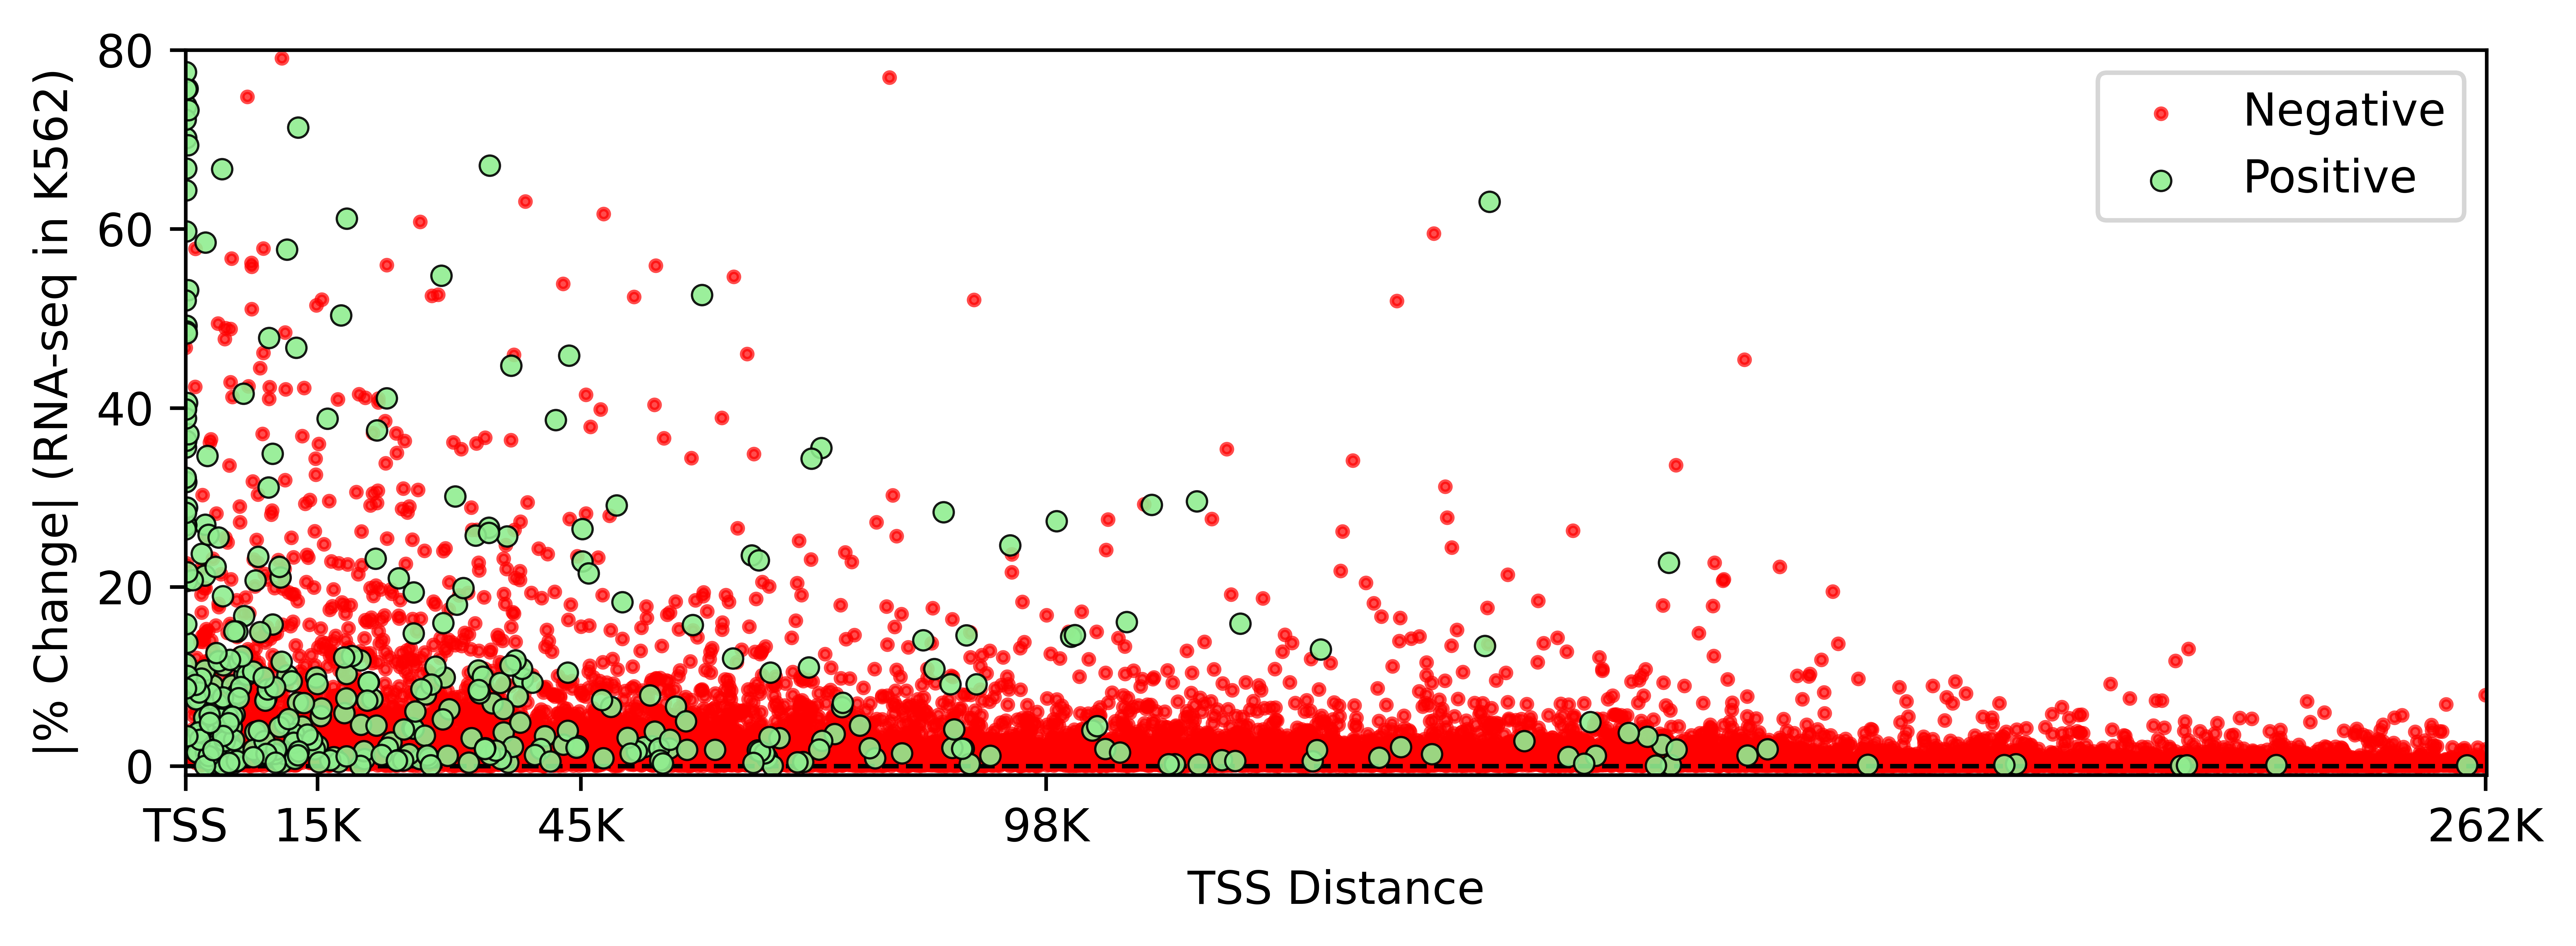

-- borzoi scores (ism shuffle; one fold) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1230	179	0.7108	0.3987	0.6970	0.4406	0.6687	0.7112	0.7542	0.3299	0.4034	0.4746
45000	2445	103	0.6729	0.1144	0.5338	0.0612	0.6111	0.6740	0.7338	0.0790	0.1204	0.1795
98000	4058	65	0.7173	0.0611	0.5789	0.0226	0.6514	0.7186	0.7857	0.0364	0.0658	0.1115
262144	10051	45	0.6578	0.0550	0.6568	0.0082	0.5561	0.6578	0.7571	0.0148	0.0562	0.1280


In [7]:
#Evaluate borzoi scores (ism shuffle; ensemble)

print("-- borzoi scores (ism shuffle; ensemble) --")

#Compute and print accuracy stats
stats_df_borzoi_ism = accuracy_stats(
    crispr_df_borzoi_ensemble_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_borzoi_ensemble_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_borzoi_ensemble_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=1200)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1, rasterized=True)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1, rasterized=True)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 262144)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 262000], ['TSS', '15K', '45K', '98K', '262K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.savefig("borzoi_gasperini_ensemble_ism_scatter.pdf")

plt.show()

print("-- borzoi scores (ism shuffle; one fold) --")

#Compute and print accuracy stats
stats_df_borzoi_ism_f0 = accuracy_stats(
    crispr_df_borzoi_f0_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)


-- enformer scores (ism shuffle) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1230	179	0.7343	0.4870	0.6970	0.4406	0.6908	0.7339	0.7765	0.4140	0.4872	0.5570
45000	2445	103	0.6471	0.0925	0.5338	0.0612	0.5867	0.6474	0.6993	0.0636	0.0977	0.1466
98000	4058	65	0.6882	0.1059	0.5789	0.0226	0.6186	0.6870	0.7525	0.0442	0.1063	0.1938
262144	0	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1230	179	3.4290	2.8572	3.4367	4.1133
45000	2445	103	2.0085	1.4374	2.0012	2.6787
98000	4058	65	3.7877	2.1453	3.7172	5.8517
262144	0	0	nan	nan	nan	nan


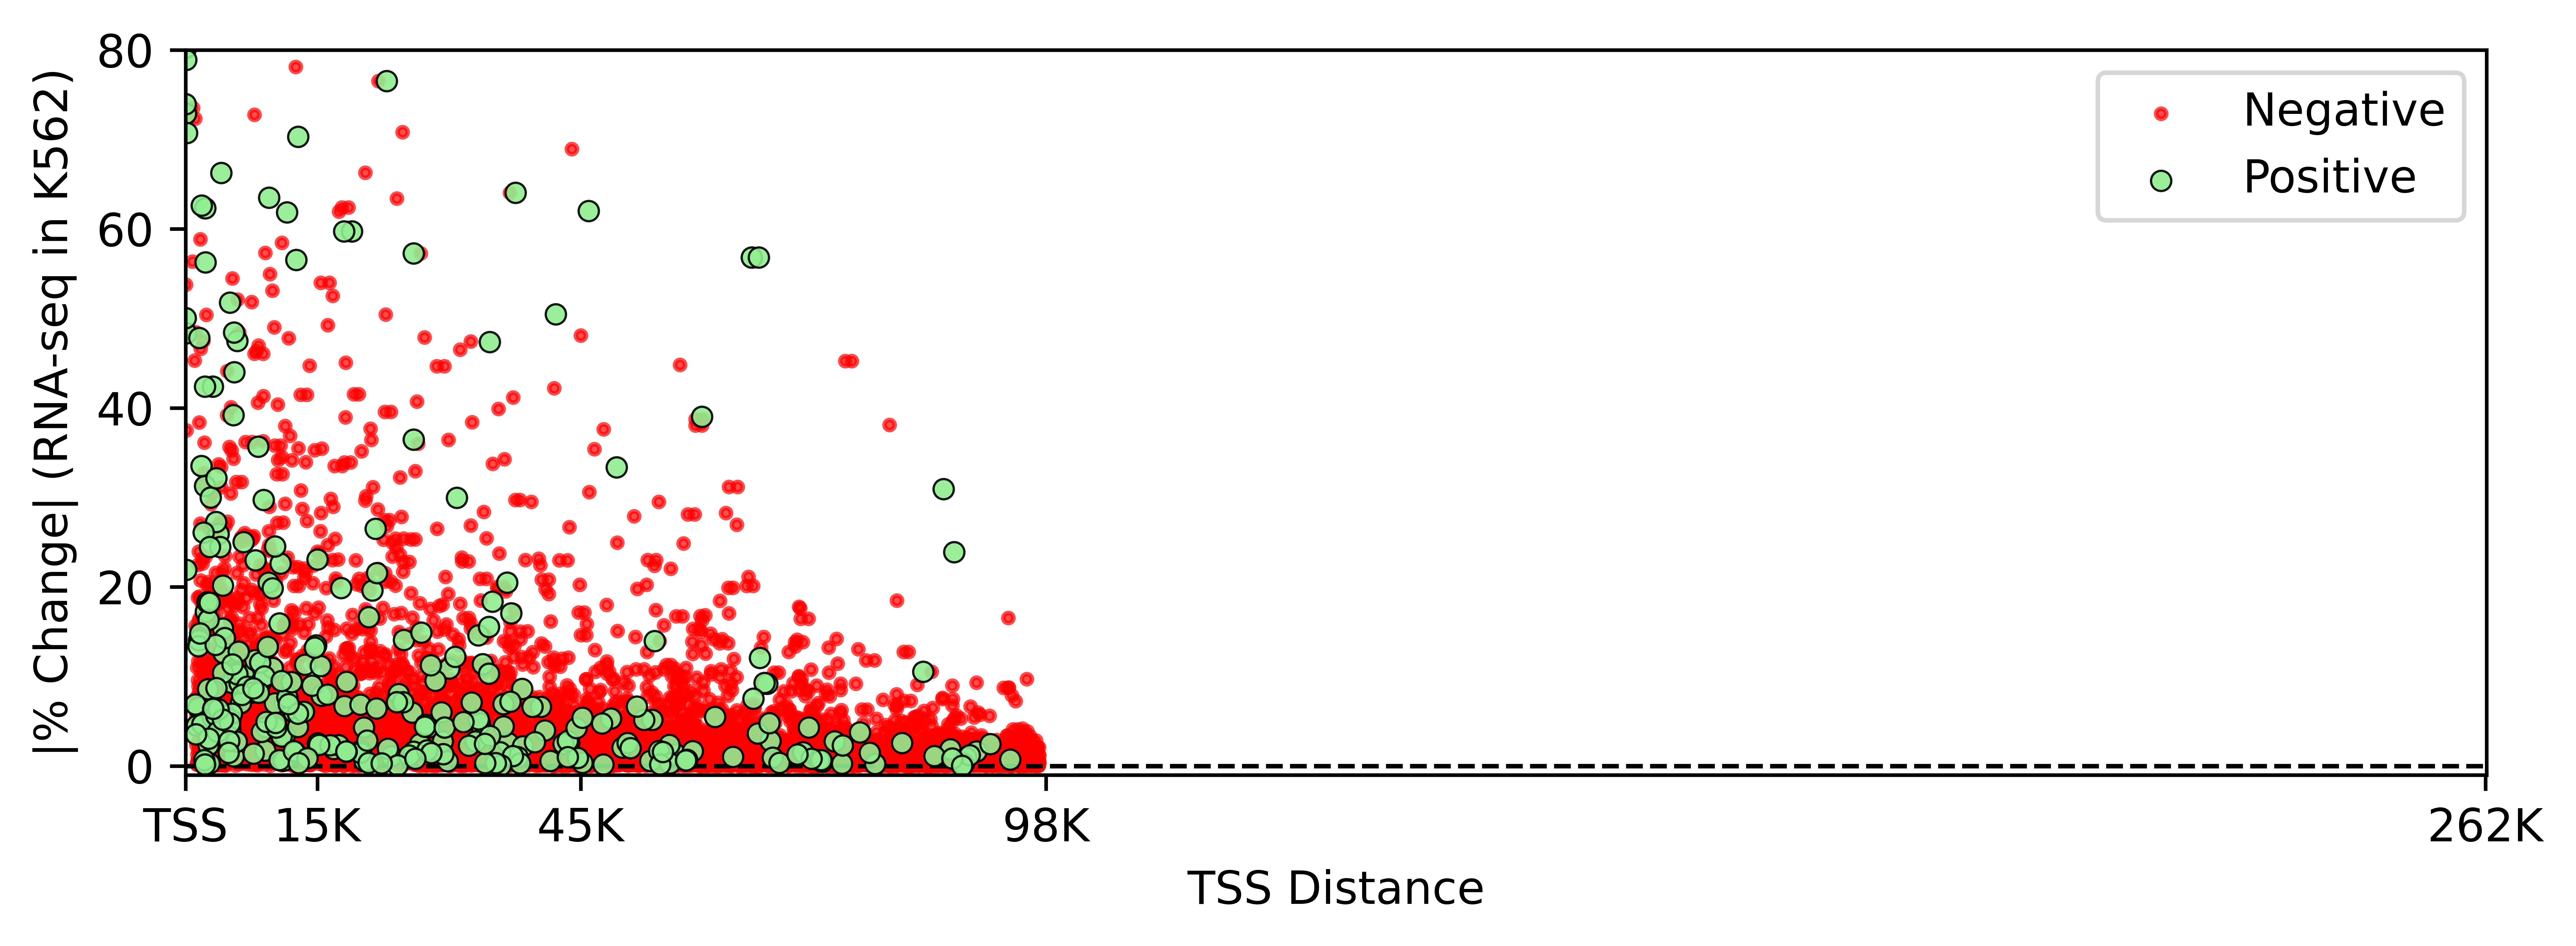

-- enformer scores (ism shuffle; max) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1230	179	0.7227	0.4688	0.6970	0.4406	0.6774	0.7232	0.7677	0.3960	0.4694	0.5501
45000	2445	103	0.6345	0.0865	0.5338	0.0612	0.5755	0.6346	0.6927	0.0604	0.0901	0.1324
98000	4058	65	0.7153	0.0992	0.5789	0.0226	0.6526	0.7156	0.7727	0.0441	0.1009	0.1791
262144	0	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan


In [8]:
#Evaluate enformer scores (ism shuffle)

print("-- enformer scores (ism shuffle) --")

#Compute and print accuracy stats
stats_df_enformer_ism = accuracy_stats(
    crispr_df_enformer_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_enformer_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_enformer_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=1200)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1, rasterized=True)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1, rasterized=True)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 262144)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 262000], ['TSS', '15K', '45K', '98K', '262K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.savefig("enformer_gasperini_ensemble_ism_scatter.pdf")

plt.show()

print("-- enformer scores (ism shuffle; max) --")

#Compute and print accuracy stats
stats_df_enformer_ism_max = accuracy_stats(
    crispr_df_enformer_ism_max,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)


In [12]:
#Create stats dataframes for TSS baseline (no bootstrapping)

#Standard baseline
stats_df_tss = stats_df_borzoi_grad[['dist', 'sites', 'pos', 'tss_auc', 'tss_ap']].copy()

stats_df_tss['auc'] = stats_df_tss['tss_auc']
stats_df_tss['ap'] = stats_df_tss['tss_ap']
stats_df_tss['auc_lo'] = stats_df_tss['auc']
stats_df_tss['auc_med'] = stats_df_tss['auc']
stats_df_tss['auc_hi'] = stats_df_tss['auc']
stats_df_tss['ap_lo'] = stats_df_tss['ap']
stats_df_tss['ap_med'] = stats_df_tss['ap']
stats_df_tss['ap_hi'] = stats_df_tss['ap']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


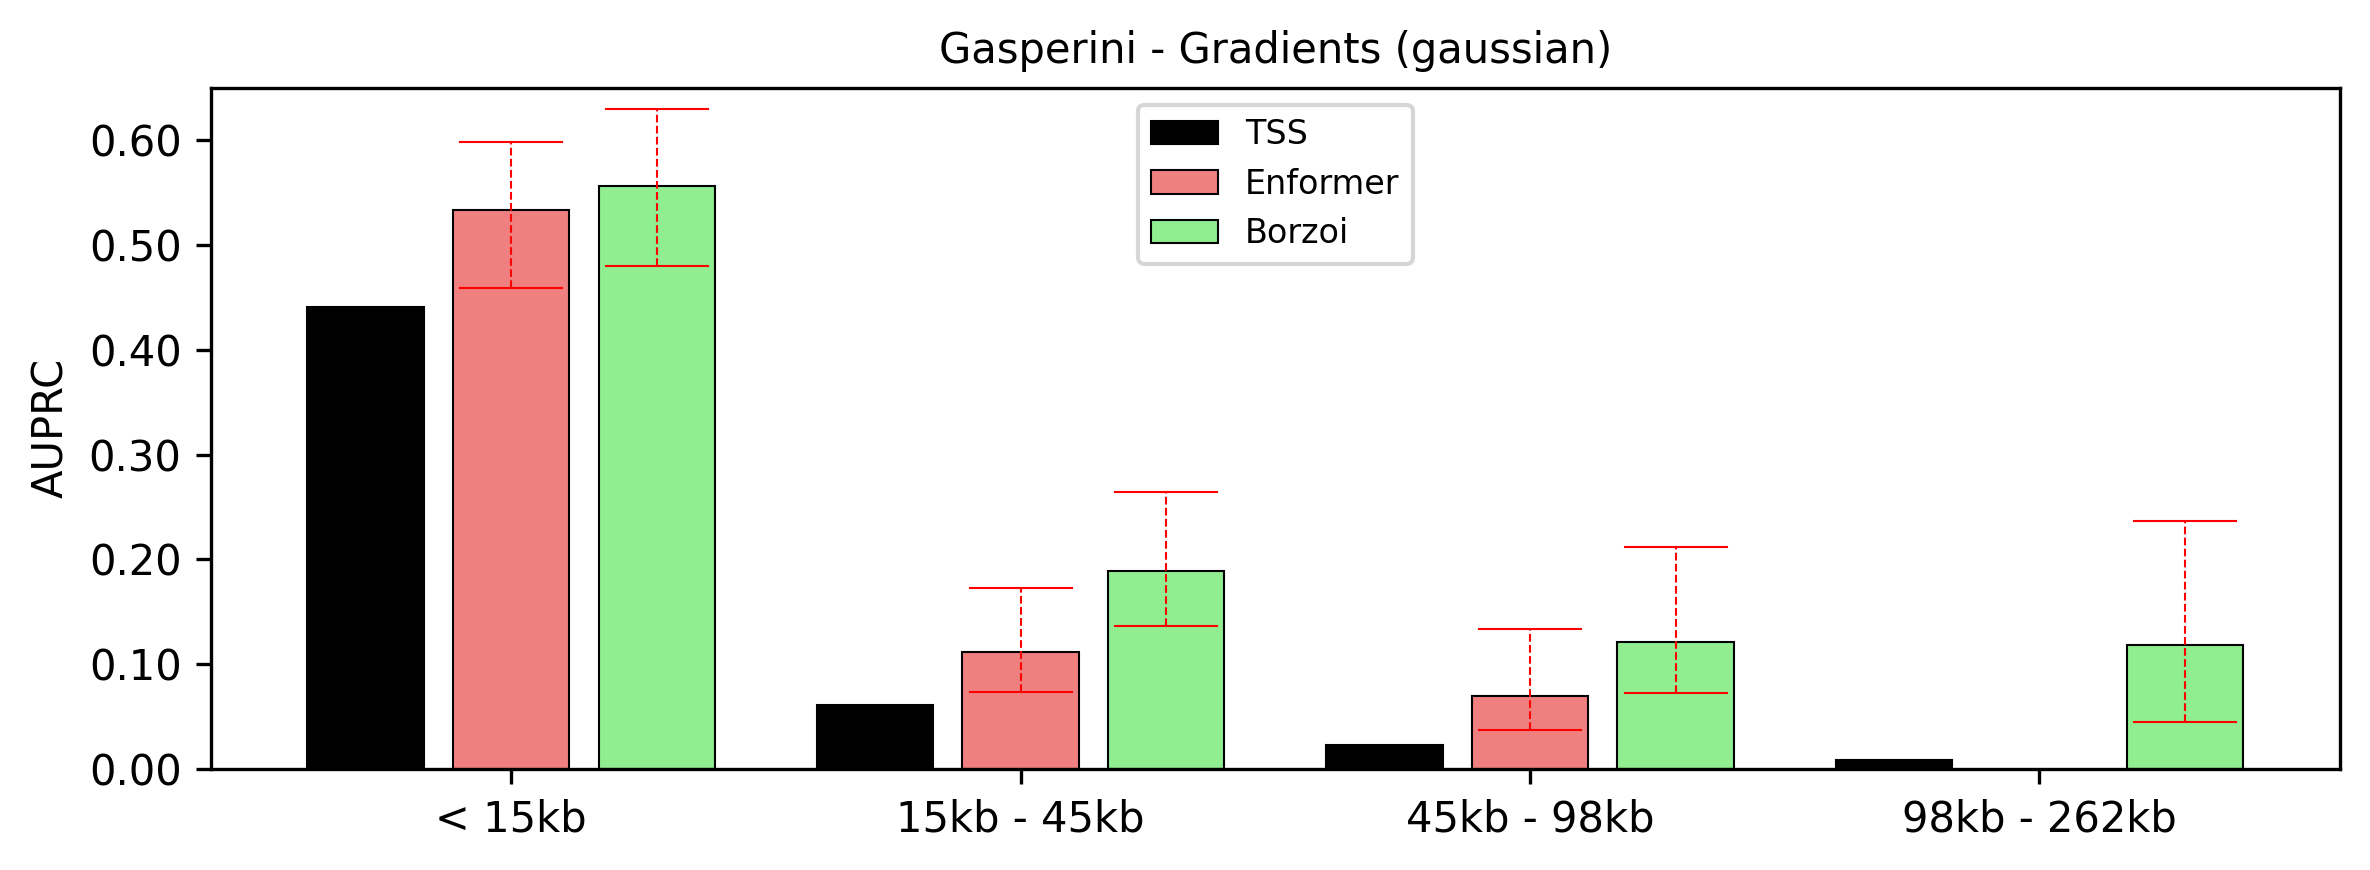

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


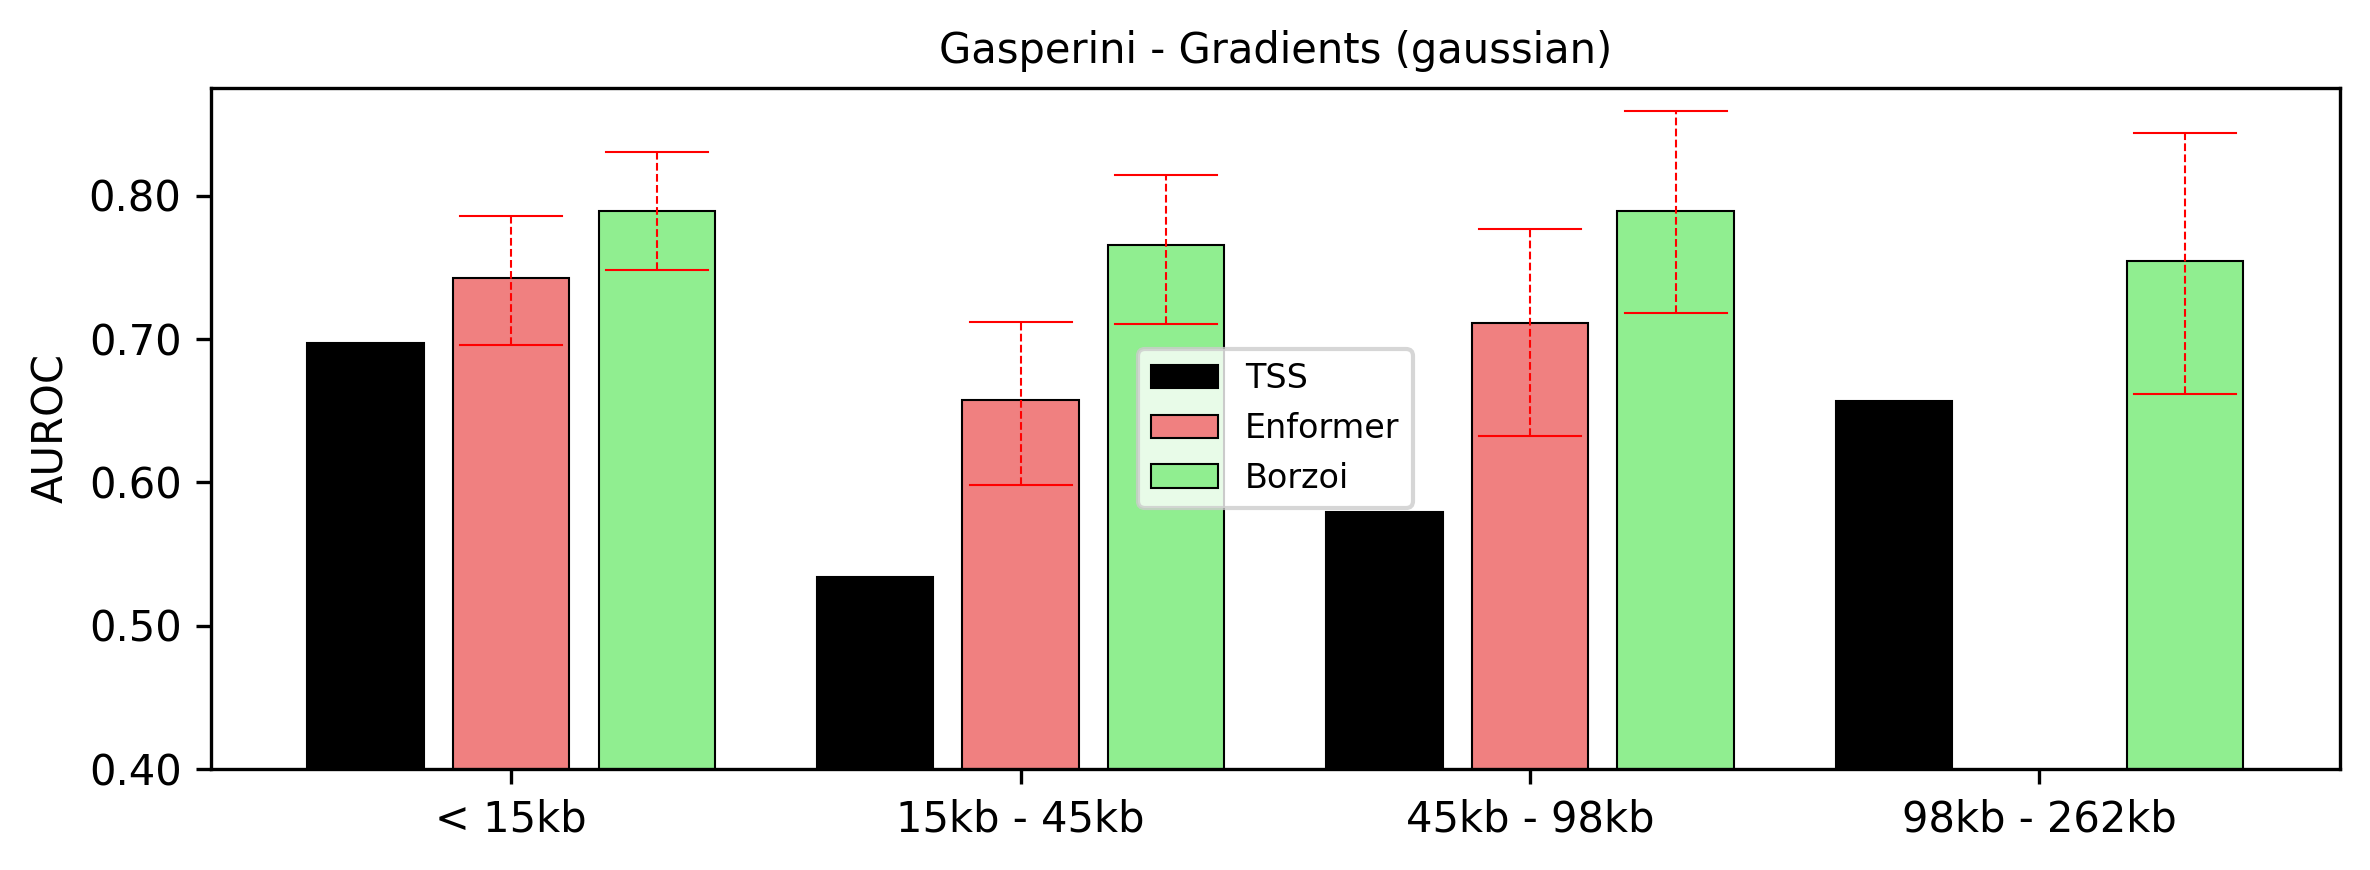

In [16]:
#Plot AUPRC bar chart with perfomance metrics (gradient; gaussian), enformer TSS mean

#Model names
model_names = [
    'TSS',
    'Enformer',
    'Borzoi',
]

#Stats dataframes
model_dfs = [
    stats_df_tss,
    stats_df_enformer_grad_gaussian,
    stats_df_borzoi_grad_gaussian,
]

#Model colors
model_colors = [
    'black',
    'lightcoral',
    'lightgreen',
]

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    plot_title='Gasperini - Gradients (gaussian)',
    metric='ap',
    metric_str='AUPRC',
    distances=[15000, 45000, 98000, 262000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 262kb'],
    y_min=0.0,
    y_max=0.65,
    save_name='gasperini_grad_bench_prc'
)

#Plot AUROC bar chart

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    plot_title='Gasperini - Gradients (gaussian)',
    metric='auc',
    metric_str='AUROC',
    distances=[15000, 45000, 98000, 262000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 262kb'],
    y_min=0.4,
    y_max=0.875,
    save_name='gasperini_grad_bench_roc'
)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


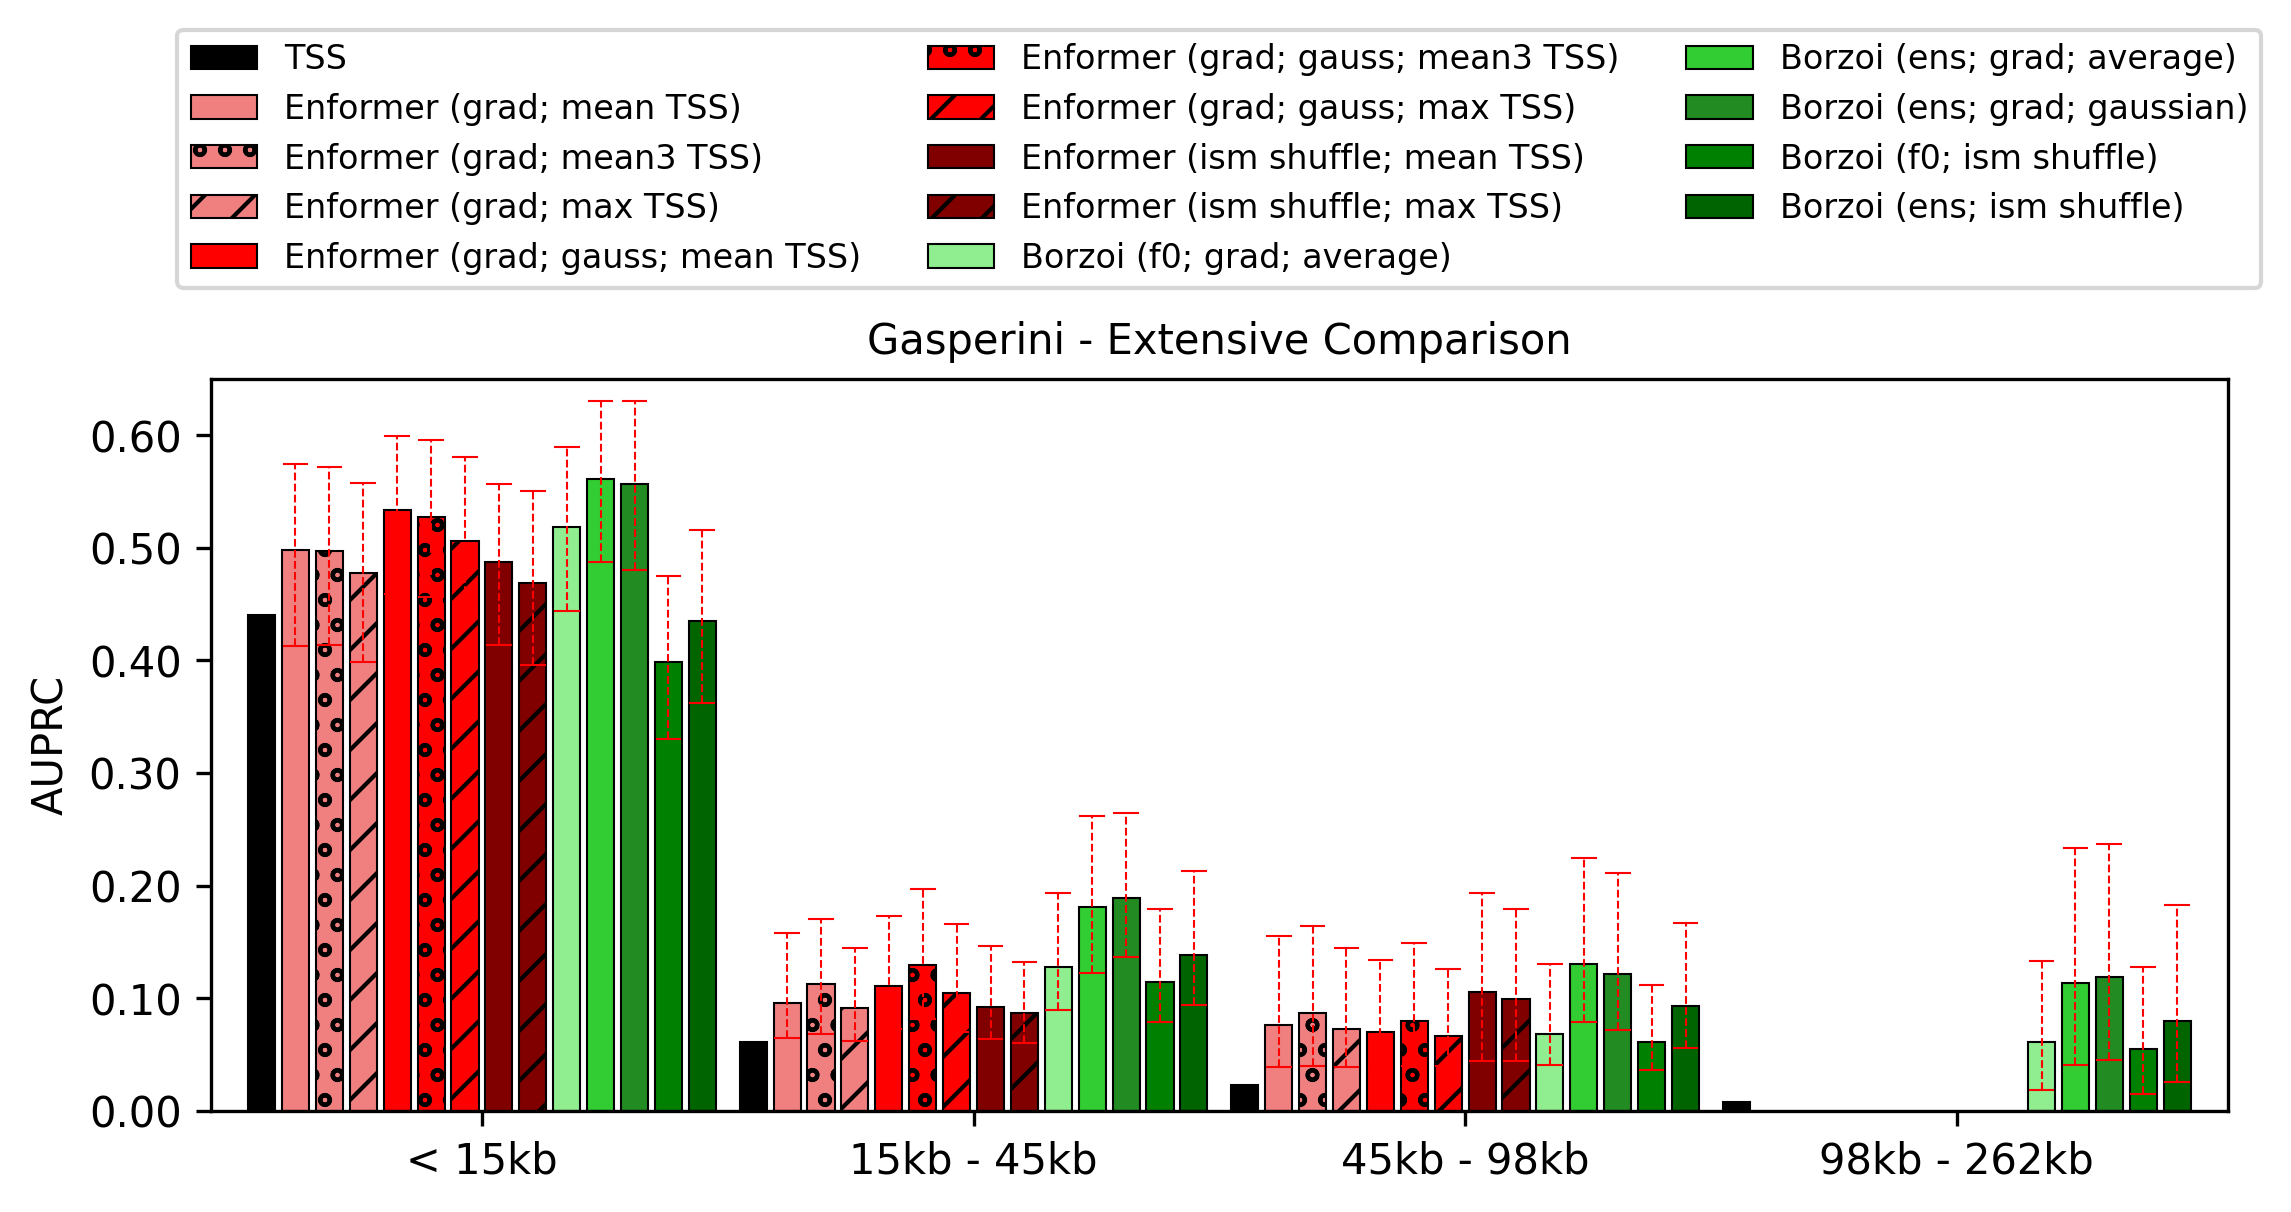

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


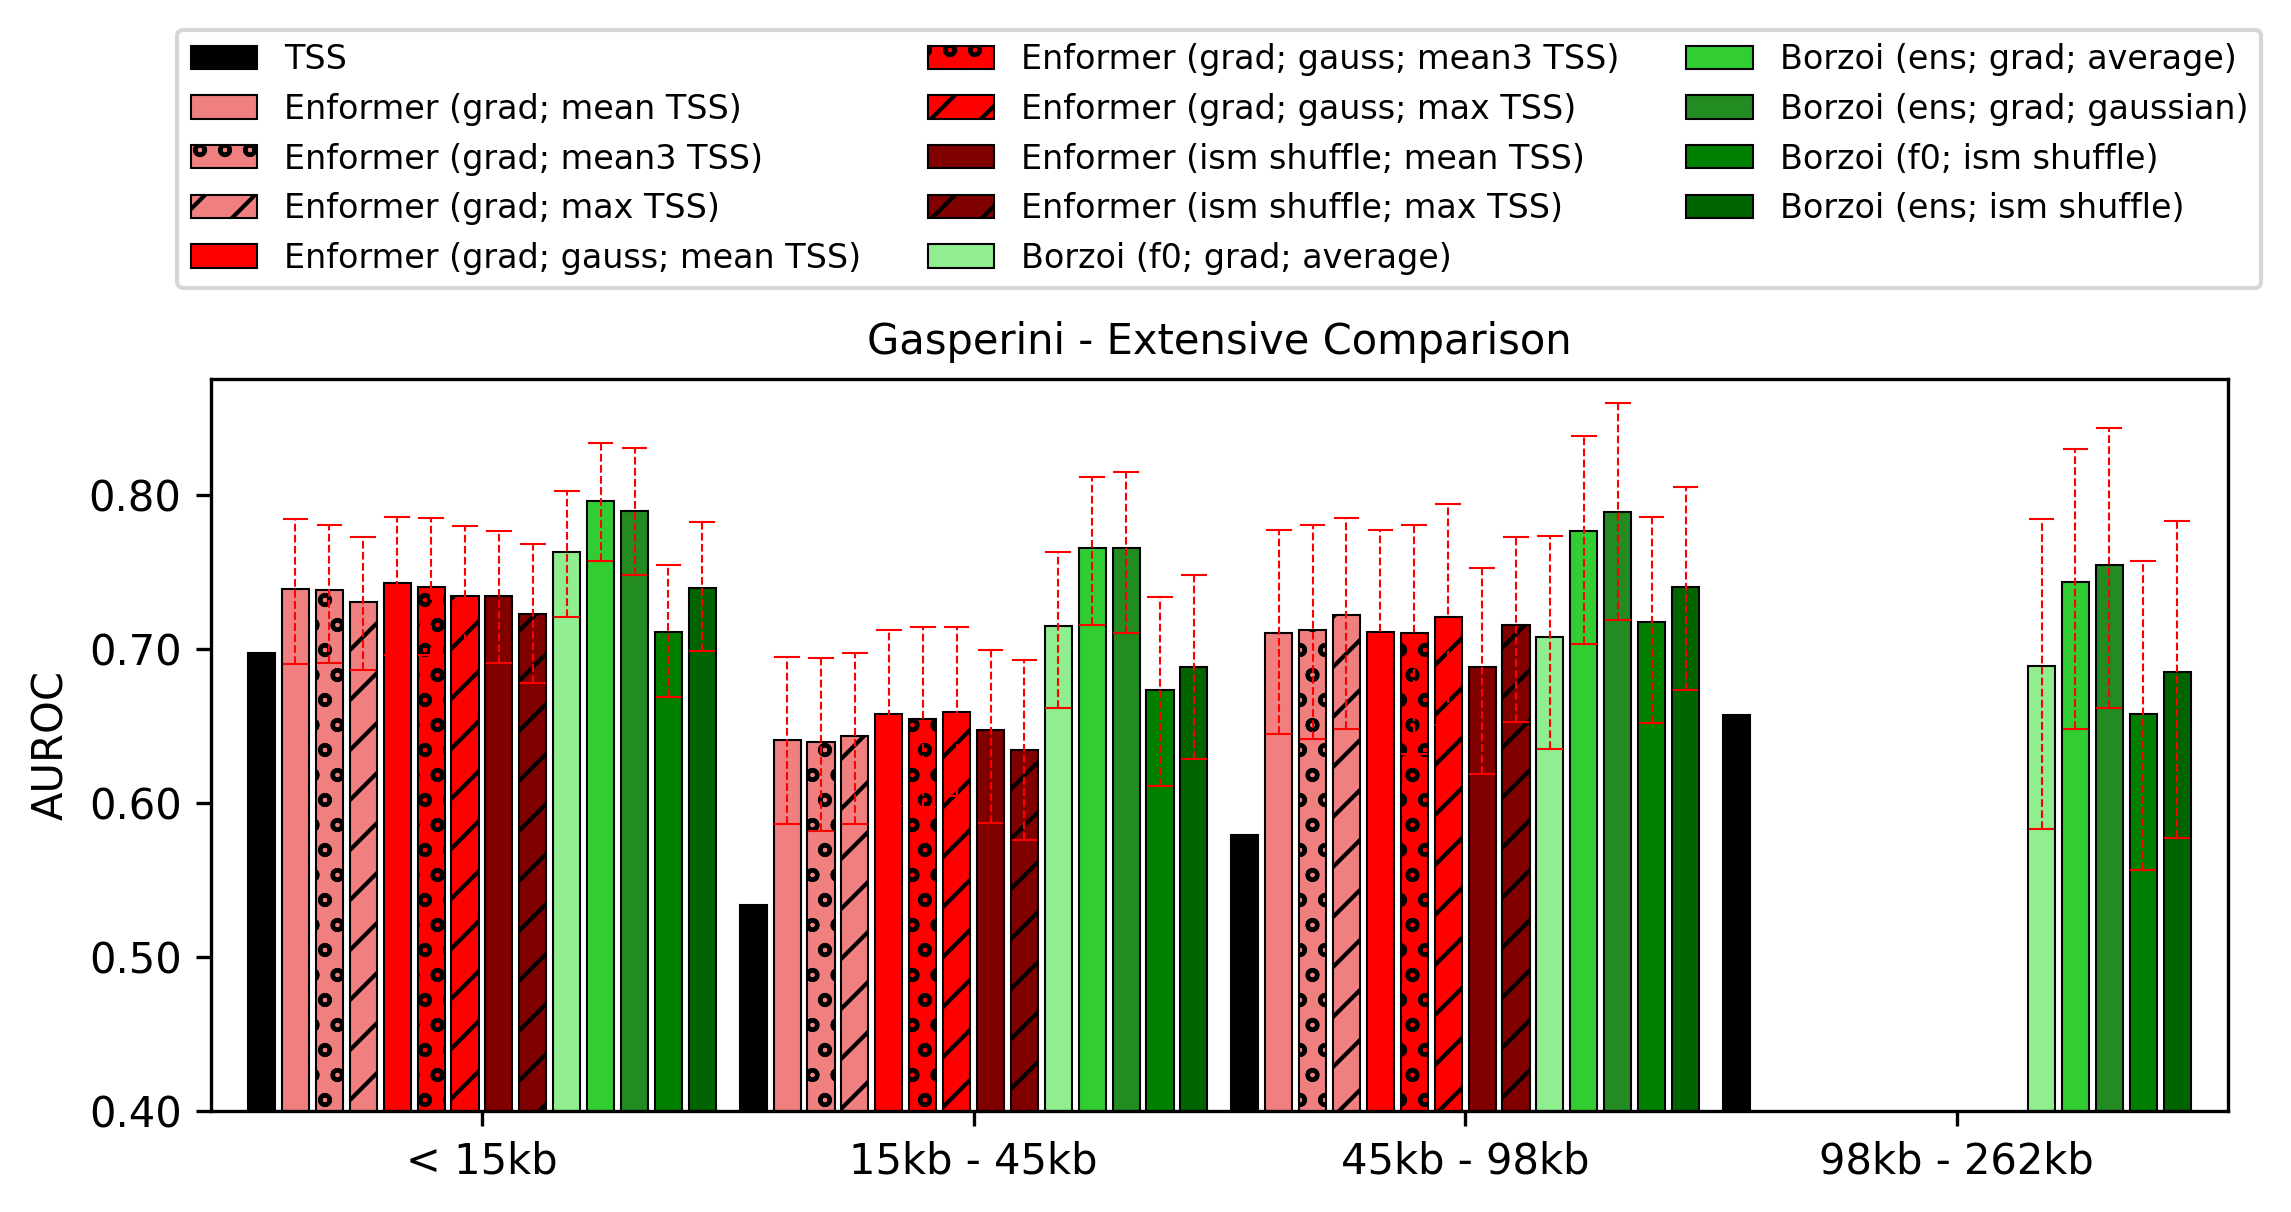

In [18]:
#Plot AUPRC bar chart with perfomance metrics (extensive comparison)

#Model names
model_names = [
    'TSS',
    'Enformer (grad; mean TSS)',
    'Enformer (grad; mean3 TSS)',
    'Enformer (grad; max TSS)',
    'Enformer (grad; gauss; mean TSS)',
    'Enformer (grad; gauss; mean3 TSS)',
    'Enformer (grad; gauss; max TSS)',
    'Enformer (ism shuffle; mean TSS)',
    'Enformer (ism shuffle; max TSS)',
    'Borzoi (f0; grad; average)',
    'Borzoi (ens; grad; average)',
    'Borzoi (ens; grad; gaussian)',
    'Borzoi (f0; ism shuffle)',
    'Borzoi (ens; ism shuffle)',
]

#Stats dataframes
model_dfs = [
    stats_df_tss,
    stats_df_enformer_grad,
    stats_df_enformer_grad3,
    stats_df_enformer_grad_max,
    stats_df_enformer_grad_gaussian,
    stats_df_enformer_grad_gaussian3,
    stats_df_enformer_grad_gaussian_max,
    stats_df_enformer_ism,
    stats_df_enformer_ism_max,
    stats_df_borzoi_grad_f0,
    stats_df_borzoi_grad,
    stats_df_borzoi_grad_gaussian,
    stats_df_borzoi_ism_f0,
    stats_df_borzoi_ism,
]

#Model colors
model_colors = [
    'black',
    'lightcoral',
    'lightcoral',
    'lightcoral',
    'red',
    'red',
    'red',
    'maroon',
    'maroon',
    'lightgreen',
    'limegreen',
    'forestgreen',
    'green',
    'darkgreen',
]

#Model hatch texture
model_hatches = [
    None,
    None,
    'oo',
    '//',
    None,
    'oo',
    '//',
    None,
    '//',
    None,
    None,
    None,
    None,
    None,
]

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    model_hatches=model_hatches,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.75),
    plot_title='Gasperini - Extensive Comparison',
    metric='ap',
    metric_str='AUPRC',
    distances=[15000, 45000, 98000, 262000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 262kb'],
    y_min=0.0,
    y_max=0.65,
    save_name='gasperini_grad_bench_prc_ext'
)

#Plot AUROC bar chart

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    model_hatches=model_hatches,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.75),
    plot_title='Gasperini - Extensive Comparison',
    metric='auc',
    metric_str='AUROC',
    distances=[15000, 45000, 98000, 262000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 262kb'],
    y_min=0.4,
    y_max=0.875,
    save_name='gasperini_grad_bench_roc_ext'
)
